## Ranga Bashyam G - M.Sc. Datascience

### Import Required Libraries 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
import cuml
from cuml.svm import SVR as cuSVR
from cuml.model_selection import GridSearchCV as cuGridSearchCV
from cuml.metrics import mean_squared_error as cu_mean_squared_error

### Load Mall dataset & print .head()

In [2]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Use .columns to view all the columns in the dataset

In [3]:
df.columns

Index(['CustomerID', 'Genre', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

### Use .isnull().sum() to viwe the null values

In [4]:
df.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## Data Pre-Processing

### Drop 'CustomerID' , as it doesnt contribute in the project

In [5]:
df = df.drop('CustomerID', axis=1)
df.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


### rename the column names to call them easily

In [6]:
df.rename(columns={'Annual Income (k$)': 'annual_income', 'Spending Score (1-100)': 'spending_score'}, inplace=True)

### One-hot encode the 'Genre' column

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('genre', OneHotEncoder(), ['Genre'])
    ],
    remainder='passthrough'
)

### Apply one-hot encoding and prepare feature and target variables

In [8]:
X = preprocessor.fit_transform(df[['Genre', 'Age', 'annual_income']])
y = df['spending_score']

In [14]:
print(X)

[[  0.   1.  19.  15.]
 [  0.   1.  21.  15.]
 [  1.   0.  20.  16.]
 [  1.   0.  23.  16.]
 [  1.   0.  31.  17.]
 [  1.   0.  22.  17.]
 [  1.   0.  35.  18.]
 [  1.   0.  23.  18.]
 [  0.   1.  64.  19.]
 [  1.   0.  30.  19.]
 [  0.   1.  67.  19.]
 [  1.   0.  35.  19.]
 [  1.   0.  58.  20.]
 [  1.   0.  24.  20.]
 [  0.   1.  37.  20.]
 [  0.   1.  22.  20.]
 [  1.   0.  35.  21.]
 [  0.   1.  20.  21.]
 [  0.   1.  52.  23.]
 [  1.   0.  35.  23.]
 [  0.   1.  35.  24.]
 [  0.   1.  25.  24.]
 [  1.   0.  46.  25.]
 [  0.   1.  31.  25.]
 [  1.   0.  54.  28.]
 [  0.   1.  29.  28.]
 [  1.   0.  45.  28.]
 [  0.   1.  35.  28.]
 [  1.   0.  40.  29.]
 [  1.   0.  23.  29.]
 [  0.   1.  60.  30.]
 [  1.   0.  21.  30.]
 [  0.   1.  53.  33.]
 [  0.   1.  18.  33.]
 [  1.   0.  49.  33.]
 [  1.   0.  21.  33.]
 [  1.   0.  42.  34.]
 [  1.   0.  30.  34.]
 [  1.   0.  36.  37.]
 [  1.   0.  20.  37.]
 [  1.   0.  65.  38.]
 [  0.   1.  24.  38.]
 [  0.   1.  48.  39.]
 [  1.   0.

In [15]:
print(y)

0      39
1      81
2       6
3      77
4      40
       ..
195    79
196    28
197    74
198    18
199    83
Name: spending_score, Length: 200, dtype: int64


### Splitting the dataset into training and testing sets

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Creating the decision tree regressor model

In [10]:
decision_tree = DecisionTreeRegressor(random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### Predicting the test set results

In [11]:
y_pred = decision_tree.predict(X_test)

### Evaluating the decision tree model

In [12]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 918.2


### Plot the decision tree

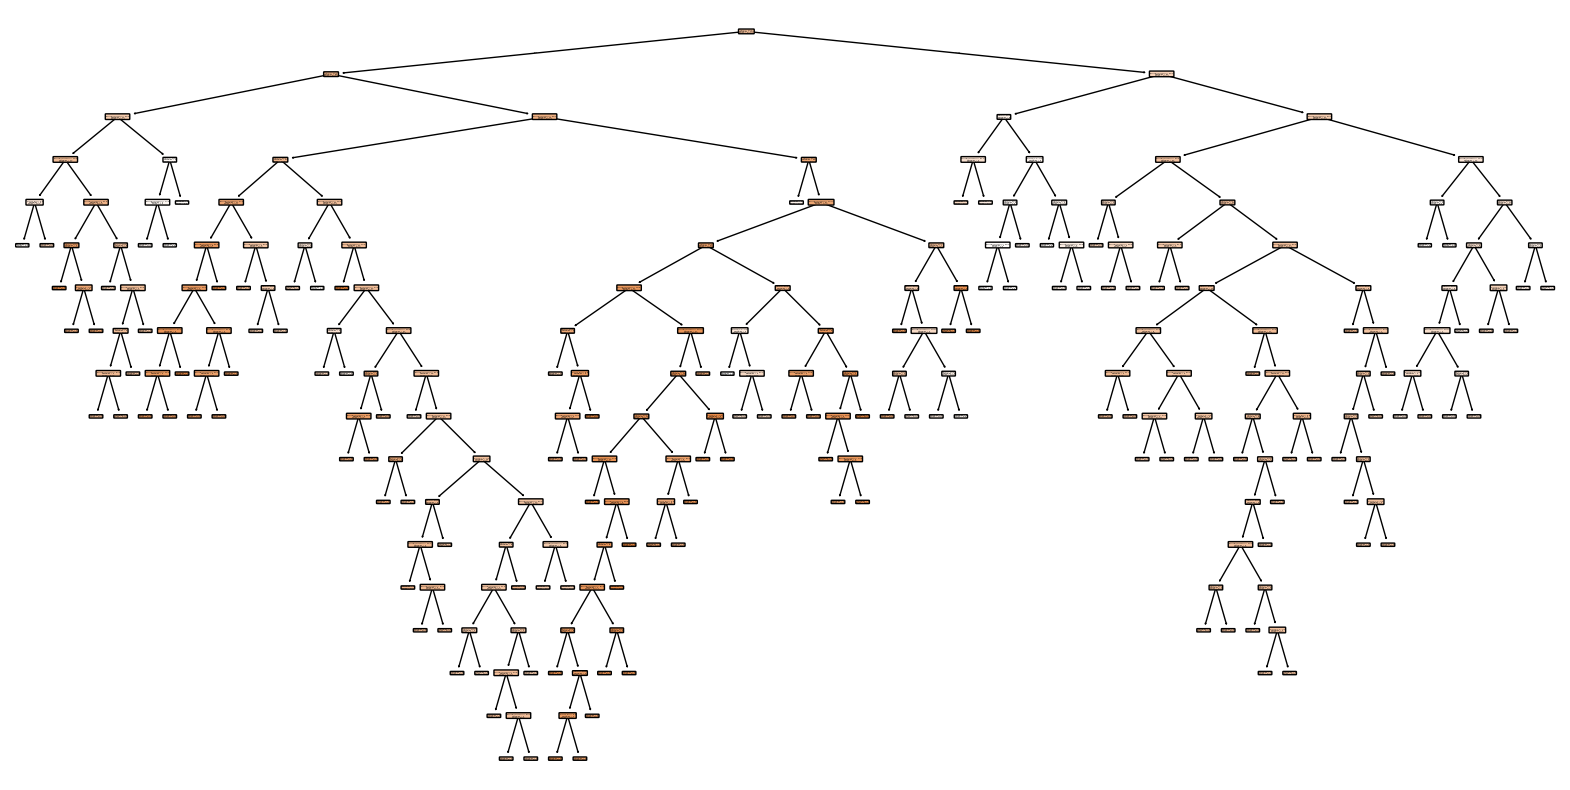

In [13]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=['Genre_F', 'Genre_M', 'Age', 'annual_income'], 
          impurity=False, rounded=True, precision=2)
plt.show()

### decision tree with enhanced visualization

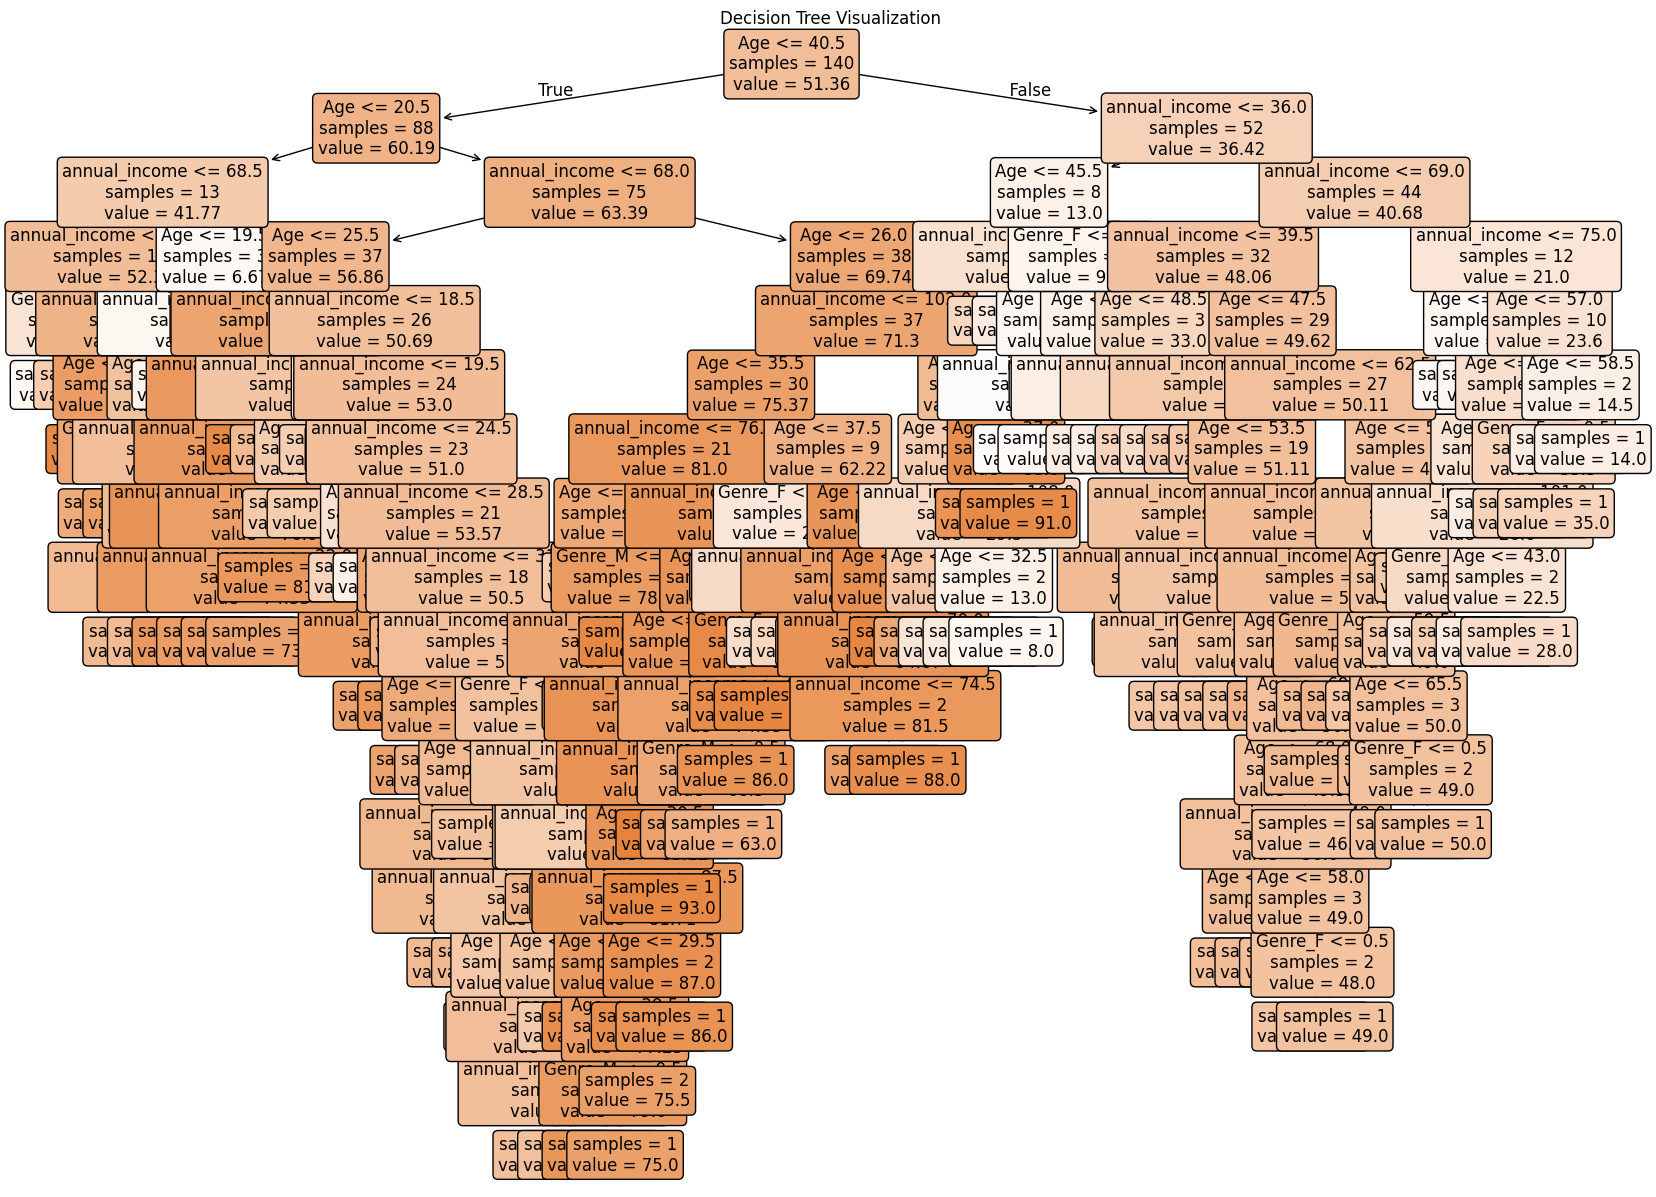

In [14]:
plt.figure(figsize=(20,15))
plot_tree(decision_tree, 
          filled=True, 
          feature_names=['Genre_F', 'Genre_M', 'Age', 'annual_income'], 
          impurity=False, 
          rounded=True, 
          precision=2, 
          fontsize=12)
plt.title("Decision Tree Visualization")
plt.show()

### Define the SVM model & parameter grid for hyperparameter tuning

In [21]:
svm = cuSVR()
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1]
}

### Perform GridSearchCV

In [16]:
grid_search = cuGridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/home/ranga/Downloads/KLU-ML/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
385 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
385 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ranga/Downloads/KLU-ML/ml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ranga/Downloads/KLU-ML/ml/lib/python3.10/site-packages/cuml/internals/api_decorators.py", line 188, in wrapper
    ret = func(*args, **kwargs)
  File "svr.pyx", line 323, in cuml.svm.svr.SVR.fit
MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /__

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error', verbose=2)

### Best parameters and model

In [22]:
best_params = grid_search.best_params_
best_svm = grid_search.best_estimator_

print("Best Parameters Found:", best_params)

Best Parameters Found: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


### Predict the test set results with the best SVM model & Evaluate

In [24]:
y_pred_svm = best_svm.predict(X_test)
mse_svm = cu_mean_squared_error(y_test, y_pred_svm)
print(f"Mean Squared Error (SVM): {mse_svm}")

Mean Squared Error (SVM): 600.9260618747375


## Compare the performance

In [25]:
if mse_svm < mse:
    print("SVM model performs better than the Decision Tree model.")
elif mse_svm > mse:
    print("Decision Tree model performs better than the SVM model.")
else:
    print("Both models perform equally well.")

SVM model performs better than the Decision Tree model.
